In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
import pingouin as pg
import seaborn as sns
from scipy.optimize import least_squares
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.stats import pearsonr,sem, spearmanr

class PsychometricFit(BaseEstimator, RegressorMixin):
    def __init__(self):
        self.slope_ = None
        self.threshold_ = None
        self.popt_ = None
        self.r_squared_ = None

    def _sigmoid(self, x, x0, k, L=1, b=0):
        return L / (1 + np.exp(-k * (x - x0))) + b

    def _residuals(self, params, x, y):
        return y - self._sigmoid(x, *params)

    def fit(self, X, y):
        initial_guess = [np.median(X), 1.0, 1.0, 0.0]
        bounds = (
            [0, 0, 0, -1],
            [1, 500, 1, 1]
        )
        result = least_squares(self._residuals, initial_guess, bounds=bounds, args=(X, y))
        self.popt_ = result.x
        self.threshold_ = result.x[0]
        self.slope_ = result.x[1]

        residuals = y - self._sigmoid(X, *result.x)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        self.r_squared_ = 1 - (ss_res / ss_tot)
        return self

    def predict(self, X):
        return self._sigmoid(X, *self.popt_)

    @property
    def slope(self):
        return self.slope_

    @property
    def threshold(self):
        return self.threshold_

    @property
    def r_squared(self):
        return self.r_squared_

    def summary_dataframe(self):
        data = {
            'slope': [self.slope_],
            'threshold': [self.threshold_],
            'x0': [self.popt_[0]],
            'k': [self.popt_[1]],
            'L': [self.popt_[2]],
            'b': [self.popt_[3]],
            'r_squared': [self.r_squared_]
        }
        return pd.DataFrame(data)


plt.rcParams['xtick.bottom'] = True  # Show ticks at the bottom of the x-axis
plt.rcParams['xtick.top'] = True     # Show ticks at the top of the x-axis
plt.rcParams['ytick.left'] = True    # Show ticks on the left side of the y-axis
plt.rcParams['ytick.right'] = True   # Show ticks on the right side of the y-axis


plt.rcParams['axes.edgecolor'] = 'k'
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'

plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5

In [2]:
intensities_real = np.array([0,50,150,300,500]) # all shock intensities
intensities_real_norm = intensities_real/500

# Vicarious Emotional Response

In [3]:
eco_zpsize_avg = pd.read_csv('Data/fig_1_2_3/eco_pupil_zscore.csv',header=[0,1],index_col=[0])
eco_zpsize_avg.columns = eco_zpsize_avg.columns.map(lambda x: tuple(map(int, x)))
eco_vel1_avg = pd.read_csv('Data/fig_1_2_3/eco_vel_zscore.csv',header=[0,1],index_col=[0])
eco_vel1_avg.columns = eco_vel1_avg.columns.map(lambda x: tuple(map(int, x)))
eco_sub_folder = pd.read_csv('Data/aversive_sub_folder.csv')

eco_zpsize_avg_diff = (eco_zpsize_avg.T - eco_zpsize_avg.xs(0,level=1,axis=1).mean(axis=1).T).T
eco_vel1_avg_diff = (eco_vel1_avg.T - eco_vel1_avg.xs(0,level=1,axis=1).mean(axis=1).T).T

ylims = dict(pupil=(-5,20),velocity=(-60,60))
xlims = [eco_zpsize_avg_diff.index[0],eco_zpsize_avg_diff.index[-1]]

## Fig. 1 B,C,D

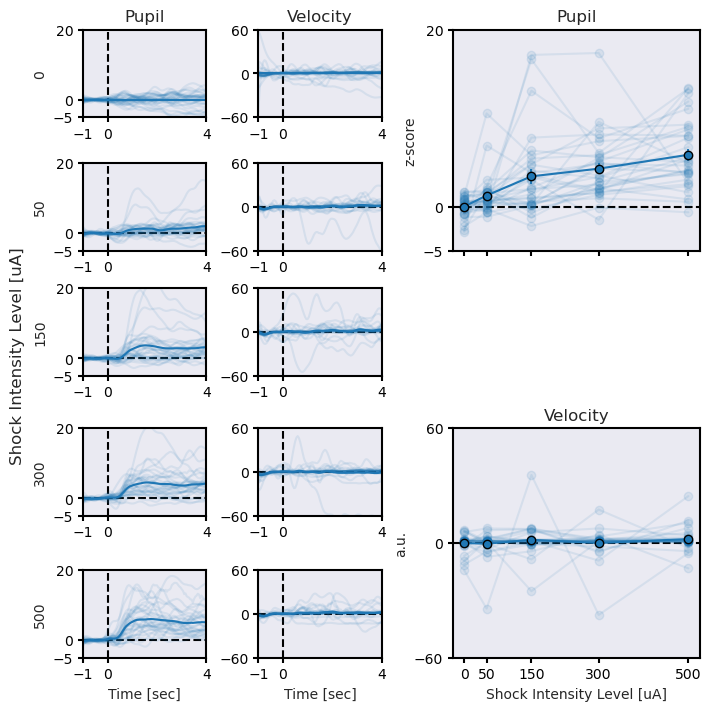

In [10]:
fig = plt.figure(layout="constrained",figsize=(7,7))

gs = GridSpec(5, 4, figure=fig)
ax_pup = dict()
ax_vel = dict()
ax_pup_peaks = fig.add_subplot(gs[0:2, 2:])
ax_vel_peaks = fig.add_subplot(gs[3:, 2:])

fig.supylabel('Shock Intensity Level [uA]')
levels = np.unique([i[1] for i in eco_zpsize_avg_diff.columns])
for i in levels:
    ax_pup[i] = fig.add_subplot(gs[i, 0])
    ax_vel[i] = fig.add_subplot(gs[i, 1])

    ax_pup[i].axhline(0,color='k',linestyle='--')
    ax_pup[i].axvline(0,color='k',linestyle='--')
    ax_pup[i].plot(eco_zpsize_avg_diff.xs(i,level=1,axis=1), alpha=0.1,color='tab:blue')
    ax_pup[i].plot(eco_zpsize_avg_diff.xs(i,level=1,axis=1).mean(axis=1),color='tab:blue')
    #ax_pup[i].set_ylim([-5,25])

    ax_vel[i].axhline(0,color='k',linestyle='--')
    ax_vel[i].axvline(0,color='k',linestyle='--')
    ax_vel[i].plot(eco_vel1_avg_diff.xs(i,level=1,axis=1), alpha=0.1,color='tab:blue')
    ax_vel[i].plot(eco_vel1_avg_diff.xs(i,level=1,axis=1).mean(axis=1),color='tab:blue')
    #ax_vel[i].set_ylim([-70,70])

    ax_pup[i].set_ylabel(str(intensities_real[i]) ) #+ ' uA'\n z-score' )
    if i == 0:
        ax_pup[i].set_title('Pupil')
        ax_vel[i].set_title('Velocity')

    if i == np.max(levels):
        ax_pup[i].set_xlabel('Time [sec]')
        ax_vel[i].set_xlabel('Time [sec]')
    ax_pup[i].grid(False)
    ax_vel[i].grid(False)
    ax_pup[i].set_xlim([eco_zpsize_avg_diff.index[0],eco_zpsize_avg_diff.index[-1]])
    ax_vel[i].set_xlim([eco_vel1_avg_diff.index[0],eco_vel1_avg_diff.index[-1]])
    ax_vel[i].tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)
    ax_pup[i].tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)
    ax_pup[i].set_ylim(ylims['pupil'])
    ax_vel[i].set_ylim(ylims['velocity'])
    ax_pup[i].set_yticks([ylims['pupil'][0],0,ylims['pupil'][1]])
    ax_vel[i].set_yticks([ylims['velocity'][0], 0,ylims['velocity'][1]])

    ax_pup[i].set_xlim([xlims[0],np.floor(xlims[1])])
    ax_vel[i].set_xlim([xlims[0],np.floor(xlims[1])])
    ax_pup[i].set_xticks([xlims[0],0,np.floor(xlims[1])])
    ax_vel[i].set_xticks([xlims[0], 0,np.floor(xlims[1])])

eco_psize_curve = eco_zpsize_avg_diff.loc[1:2].mean().reset_index()
eco_psize_curve['intensity'] = eco_psize_curve['intensity'].apply(lambda x: intensities_real[x])
for su in eco_psize_curve['sub'].unique():
    temp_sub = eco_psize_curve[eco_psize_curve['sub']==su]
    ax_pup_peaks.errorbar( temp_sub['intensity'], temp_sub[0], color='tab:blue', marker='o', markerfacecolor='tab:blue', linestyle='-',markeredgecolor=None, alpha=.1 )
eco_psize_curve_avg = eco_psize_curve.groupby('intensity').mean().reset_index()
eco_psize_curve_sem = eco_psize_curve.groupby('intensity').sem().reset_index()
ax_pup_peaks.errorbar( eco_psize_curve_avg['intensity'], eco_psize_curve_avg[0], yerr=eco_psize_curve_sem[0], color='tab:blue', marker='o', markerfacecolor='tab:blue', linestyle='-',markeredgecolor='k', alpha=1 )
ax_pup_peaks.axhline(y=0, color='k',linestyle='--')
ax_pup_peaks.set_ylabel('z-score')
ax_pup_peaks.set_title('Pupil')
#ax_pup_peaks.set_xlabel('Shock Intensity Level [uA]')
ax_pup_peaks.grid(False)
ax_pup_peaks.set_xticks(intensities_real[levels])
ax_pup_peaks.set_xticklabels([])
ax_pup_peaks.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)
ax_pup_peaks.set_yticks([ylims['pupil'][0],0,ylims['pupil'][1]])

eco_vel_curve = eco_vel1_avg_diff.loc[1:2].mean().reset_index()
eco_vel_curve['intensity'] = eco_vel_curve['intensity'].apply(lambda x: intensities_real[x])
for su in eco_vel_curve['sub'].unique():
    temp_sub = eco_vel_curve[eco_vel_curve['sub']==su]
    ax_vel_peaks.errorbar( temp_sub['intensity'], temp_sub[0], color='tab:blue', marker='o', markerfacecolor='tab:blue', linestyle='-',markeredgecolor=None, alpha=.1 )
#ax_vel_peaks.errorbar( eco_vel_curve['intensity'], eco_vel_curve[0], color='tab:blue', marker='o', markerfacecolor='tab:blue', linestyle='-',markeredgecolor=None, alpha=.1 )
eco_vel_curve_avg = eco_vel_curve.groupby('intensity').mean().reset_index()
eco_vel_curve_sem = eco_vel_curve.groupby('intensity').sem().reset_index()
ax_vel_peaks.errorbar( eco_vel_curve_avg['intensity'], eco_vel_curve_avg[0], yerr=eco_vel_curve_sem[0], color='tab:blue', marker='o', markerfacecolor='tab:blue', linestyle='-',markeredgecolor='k', alpha=1 )
ax_vel_peaks.axhline(y=0, color='k',linestyle='--')
ax_vel_peaks.set_ylabel('a.u.')
ax_vel_peaks.set_title('Velocity')
ax_vel_peaks.set_xlabel('Shock Intensity Level [uA]')
ax_vel_peaks.grid(False)
ax_vel_peaks.set_xticks(intensities_real[levels])
ax_vel_peaks.tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)


ax_vel_peaks.set_yticks([ylims['velocity'][0], 0,ylims['velocity'][1]])

In [11]:
EC_anova = pg.rm_anova(data=eco_psize_curve.rename(columns={0:'value'}), dv='value', within='intensity',
                       subject='sub',
                       )
EC_anova.insert(0,'Test','anova_rm')
EC_anova.insert(1,'N', eco_psize_curve['sub'].unique().size)
EC_post_hoc = pg.pairwise_tests(data=eco_psize_curve.rename(columns={0:'value'}), dv='value', within='intensity',
                                subject='sub', padjust='fdr_bh').sort_values(by='p-corr')
EC_post_hoc['signi']=''
EC_post_hoc['signi'] = EC_post_hoc['p-corr'].apply(lambda x: '***' if x<0.001 else '**' if x<0.01 else '*' if x<0.05 else '')
EC_post_hoc.insert(0,'Test','anova_rm_post_hoc')
EC_all_stats = pd.concat([EC_anova,EC_post_hoc.drop('signi',axis=1)])

print('Pupil Statistics:')
EC_all_stats

Pupil Statistics:


,Test,N,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,...,B,Paired,Parametric,T,dof,alternative,p-corr,p-adjust,BF10,hedges
0,anova_rm,32.0,intensity,4.0,124.0,20.274482,7.200275e-13,5.816549e-10,0.291508,0.728408,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,anova_rm_post_hoc,NaN,NaN,NaN,NaN,NaN,1.701251e-09,NaN,NaN,NaN,...,500,True,True,-8.406529,31.0,two-sided,1.701251e-08,fdr_bh,6.888e+06,-2.047712
2,anova_rm_post_hoc,NaN,NaN,NaN,NaN,NaN,1.646849e-07,NaN,NaN,NaN,...,300,True,True,-6.712113,31.0,two-sided,8.234247e-07,fdr_bh,9.393e+04,-1.597394
6,anova_rm_post_hoc,NaN,NaN,NaN,NaN,NaN,7.915119e-07,NaN,NaN,NaN,...,500,True,True,-6.154346,31.0,two-sided,2.638373e-06,fdr_bh,2.177e+04,-1.456930
1,anova_rm_post_hoc,NaN,NaN,NaN,NaN,NaN,2.484123e-04,NaN,NaN,NaN,...,150,True,True,-4.138220,31.0,two-sided,4.968245e-04,fdr_bh,112.717,-0.992857
5,anova_rm_post_hoc,NaN,NaN,NaN,NaN,NaN,2.277450e-04,NaN,NaN,NaN,...,300,True,True,-4.169221,31.0,two-sided,4.968245e-04,fdr_bh,121.866,-1.011195
8,anova_rm_post_hoc,NaN,NaN,NaN,NaN,NaN,7.137295e-03,NaN,NaN,NaN,...,500,True,True,-2.880757,31.0,two-sided,1.189549e-02,fdr_bh,5.873,-0.565359
0,anova_rm_post_hoc,NaN,NaN,NaN,NaN,NaN,8.820872e-03,NaN,NaN,NaN,...,50,True,True,-2.795241,31.0,two-sided,1.260125e-02,fdr_bh,4.902,-0.691055
4,anova_rm_post_hoc,NaN,NaN,NaN,NaN,NaN,1.927348e-02,NaN,NaN,NaN,...,150,True,True,-2.468770,31.0,two-sided,2.409185e-02,fdr_bh,2.539,-0.587032
9,anova_rm_post_hoc,NaN,NaN,NaN,NaN,NaN,7.279442e-02,NaN,NaN,NaN,...,500,True,True,-1.857280,31.0,two-sided,8.088269e-02,fdr_bh,0.868,-0.420837


In [12]:
EC_anova = pg.rm_anova(data=eco_vel_curve.rename(columns={0:'value'}), dv='value', within='intensity',
                       subject='sub',
                       )
EC_anova.insert(0,'Test','anova_rm')
EC_anova.insert(1,'N', eco_vel_curve['sub'].unique().size)
EC_post_hoc = pg.pairwise_tests(data=eco_vel_curve.rename(columns={0:'value'}), dv='value', within='intensity',
                                subject='sub', padjust='fdr_bh').sort_values(by='p-corr')
EC_post_hoc['signi']=''
EC_post_hoc['signi'] = EC_post_hoc['p-corr'].apply(lambda x: '***' if x<0.001 else '**' if x<0.01 else '*' if x<0.05 else '')
EC_post_hoc.insert(0,'Test','anova_rm_post_hoc')
EC_all_stats = pd.concat([EC_anova,EC_post_hoc.drop('signi',axis=1)])
print('Locomotor Statistics:')
EC_all_stats

Locomotor Statistics:


,Test,N,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,...,B,Paired,Parametric,T,dof,alternative,p-corr,p-adjust,BF10,hedges
0,anova_rm,32.0,intensity,4.0,124.0,0.828172,0.509659,0.429333,0.020887,0.442571,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,anova_rm_post_hoc,NaN,NaN,NaN,NaN,NaN,0.107294,NaN,NaN,NaN,...,500,True,True,-1.658541,31.0,two-sided,0.536472,fdr_bh,0.646,-0.382127
6,anova_rm_post_hoc,NaN,NaN,NaN,NaN,NaN,0.061918,NaN,NaN,NaN,...,500,True,True,-1.936898,31.0,two-sided,0.536472,fdr_bh,0.986,-0.376068
1,anova_rm_post_hoc,NaN,NaN,NaN,NaN,NaN,0.376050,NaN,NaN,NaN,...,150,True,True,-0.898109,31.0,two-sided,0.796225,fdr_bh,0.274,-0.244459
4,anova_rm_post_hoc,NaN,NaN,NaN,NaN,NaN,0.398113,NaN,NaN,NaN,...,150,True,True,-0.856833,31.0,two-sided,0.796225,fdr_bh,0.265,-0.265481
9,anova_rm_post_hoc,NaN,NaN,NaN,NaN,NaN,0.271966,NaN,NaN,NaN,...,500,True,True,-1.118453,31.0,two-sided,0.796225,fdr_bh,0.334,-0.285817
0,anova_rm_post_hoc,NaN,NaN,NaN,NaN,NaN,0.692391,NaN,NaN,NaN,...,50,True,True,0.399326,31.0,two-sided,0.873207,fdr_bh,0.203,0.064781
5,anova_rm_post_hoc,NaN,NaN,NaN,NaN,NaN,0.698566,NaN,NaN,NaN,...,300,True,True,-0.390871,31.0,two-sided,0.873207,fdr_bh,0.203,-0.052507
7,anova_rm_post_hoc,NaN,NaN,NaN,NaN,NaN,0.541399,NaN,NaN,NaN,...,300,True,True,0.617525,31.0,two-sided,0.873207,fdr_bh,0.225,0.200286
8,anova_rm_post_hoc,NaN,NaN,NaN,NaN,NaN,0.840833,NaN,NaN,NaN,...,500,True,True,-0.202521,31.0,two-sided,0.934259,fdr_bh,0.192,-0.049985


## Fig. 1 E

9;27;28;

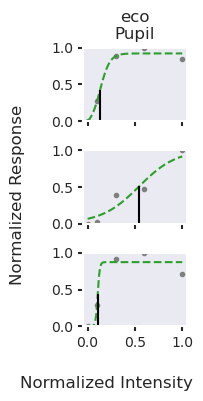

In [35]:
eco_zpsize_avg_pnt = eco_zpsize_avg_diff.loc[0:].mean().unstack()


fig,ax = plt.subplots(3,1,figsize=(2,4),sharey=True,sharex=True)
fig.supylabel('Normalized Response')
fig.supxlabel('Normalized Intensity')
a = 0
for i in range(eco_zpsize_avg_pnt.shape[0]):
    if i in [9,27,28]:
        print(i,end=';')
        ladder = eco_zpsize_avg_pnt.loc[i,:]
        x_values = (np.array([0,50,150,300,500])/500)
        y_values = (ladder.values-ladder.values[0])/np.max(ladder.values-ladder.values[0])
        psych_eco_zpsize = PsychometricFit()
        psych_eco_zpsize.fit(x_values,y_values)
        x_pred = np.linspace(0,max(x_values),100)
        y_pred = psych_eco_zpsize.predict(x_pred)
        ax[a].plot(x_values, y_values, markersize=3,color='tab:gray',marker='o',linestyle='None')
        ax[a].plot(x_pred, y_pred, color='tab:green',linestyle='--')
        lims = ax[a].get_ylim()
        ax[a].vlines(psych_eco_zpsize.threshold,color='k',linestyle='-', ymax=psych_eco_zpsize.predict(psych_eco_zpsize.threshold), ymin=-0.05)
        ax[a].grid(False)

        ax[a].set_yticks([0,0.5,1])
        ax[a].set_xticks([0,0.5,1])
        ax[a].set_ylim([0,1])
        if a==0:
            ax[a].set_title('eco\nPupil')
            #ax[a,2].set_title('CONTAGION\nPupil')

        ax[a].tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)


        a+=1


plt.tight_layout()

## Fig. 1 F

In [20]:
aversive_zpsize_avg = pd.read_csv('Data/fig_1_2_3/aversive_pupil_zscore.csv',header=[0,1],index_col=[0])
aversive_zpsize_avg.columns = aversive_zpsize_avg.columns.map(lambda x: tuple(map(int, x)))
aversive_vel1_avg = pd.read_csv('Data/fig_1_2_3/aversive_vel_zscore.csv',header=[0,1],index_col=[0])
aversive_vel1_avg.columns = aversive_vel1_avg.columns.map(lambda x: tuple(map(int, x)))
aversive_sub_folder = pd.read_csv('Data/aversive_sub_folder.csv')

aversive_zpsize_avg_diff = (aversive_zpsize_avg.T - aversive_zpsize_avg.xs(0,level=1,axis=1).mean(axis=1).T).T
aversive_vel1_avg_diff = (aversive_vel1_avg.T - aversive_vel1_avg.xs(0,level=1,axis=1).mean(axis=1).T).T

aversive_zpsize_avg_pnt = aversive_zpsize_avg_diff.loc[0:].mean().unstack()
aversive_vel1_avg_pnt = aversive_vel1_avg_diff.loc[0:].mean().unstack()
eco_zpsize_avg_pnt = eco_zpsize_avg_diff.loc[0:].mean().unstack()


msize = 3
fit_res = list()
for i in range(aversive_zpsize_avg_pnt.shape[0]):
    print(i,end=';')
    ladder = aversive_zpsize_avg_pnt.loc[i,:]
    x_values = (np.array([0,50,150,300,500])/500)
    y_values = (ladder.values-ladder.values[0])/np.max(ladder.values-ladder.values[0])
    psych_aversive_zpsize = PsychometricFit()
    psych_aversive_zpsize.fit(x_values,y_values)

    ladder = aversive_vel1_avg_pnt.loc[i,:]
    x_values = (np.array([0,50,150,300,500])/500)
    y_values = (ladder.values-ladder.values[0])/np.max(ladder.values-ladder.values[0])
    psych_aversive_vel1 = PsychometricFit()
    psych_aversive_vel1.fit(x_values,y_values)


    ladder = eco_zpsize_avg_pnt.loc[i,:]
    x_values = (np.array([0,50,150,300,500])/500)
    y_values = (ladder.values-ladder.values[0])/np.max(ladder.values-ladder.values[0])
    psych_eco_zpsize = PsychometricFit()
    psych_eco_zpsize.fit(x_values,y_values)

    temp = pd.concat([psych_aversive_zpsize.summary_dataframe().add_prefix('pp_'),
                      psych_aversive_vel1.summary_dataframe().add_prefix('pv_'),
                      psych_eco_zpsize.summary_dataframe().add_prefix('ep_')],axis=1)
    temp.index=[i]
    fit_res.append(temp)

fit_res = pd.concat(fit_res)



0;1;2;3;4;5;6;7;8;9;10;11;12;13;14;15;16;17;18;19;20;21;22;23;24;25;26;27;28;29;30;31;

<Figure size 640x480 with 0 Axes>

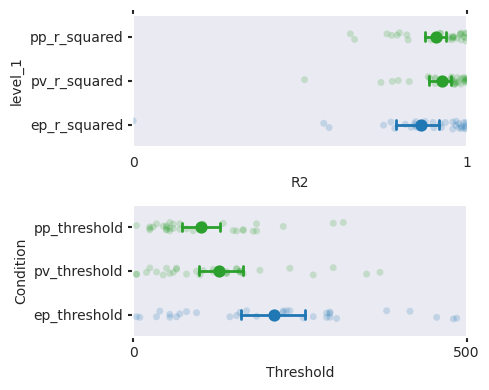

In [22]:
gof_level = -1
x_data = fit_res[['pp_threshold']][fit_res['pp_r_squared']>gof_level].values*500
y_data = fit_res[['pv_threshold']][fit_res['pp_r_squared']>gof_level].values*500
y_data_eco = fit_res[['ep_threshold']][fit_res['ep_r_squared']>gof_level].values*500
fig,ax = plt.subplots(2,1, figsize=(5,4))

r2_stacked = fit_res[['pp_r_squared','pv_r_squared','ep_r_squared']].rename(columns={'pain_pupil_r_square':'PAIN\npupil','pain_vel1_r_square':'PAIN\nvelocity','eco_pupil_r_square':'CONTAGION\npupil'}).stack().reset_index()
r2_stacked = r2_stacked.rename(columns={0:'R2'})
sns.stripplot(data=r2_stacked,x='R2', y='level_1',hue='level_1',alpha=.2,ax=ax[0],palette=['tab:green','tab:green','tab:blue'])
sns.pointplot(data=r2_stacked,x='R2', y='level_1',hue='level_1',alpha=1,linestyle='None',ax=ax[0],capsize=0.2, err_kws={'linewidth':2},palette=['tab:green','tab:green','tab:blue'])
ax[0].grid(False)

per_kde = fit_res[(fit_res['pp_r_squared']>gof_level)&(fit_res['pv_r_squared']>gof_level)][['pp_threshold','pv_threshold','ep_threshold']].stack().reset_index().rename(columns={'level_1':'Condition',0:'Threshold','level_0':'intensity'})
per_kde['Threshold'] = (per_kde['Threshold']).round(2)*500
sns.stripplot(per_kde,x='Threshold', y='Condition',hue='Condition', color='tab:blue', ax=ax[1],alpha=0.2,palette=['tab:green','tab:green','tab:blue'])
sns.pointplot(per_kde,x='Threshold', y='Condition',hue='Condition', color='tab:blue', ax=ax[1],linestyle='None',alpha=1,capsize=0.2, err_kws={'linewidth':2},palette=['tab:green','tab:green','tab:blue'])
#ax[0,1].legend().remove()
ax[1].grid(False)

ax[0].tick_params(axis='both', which='both', bottom=False, top=True, left=True, right=False)
ax[1].tick_params(axis='both', which='both', bottom=True, top=False, left=True, right=False)

xlims = [0,1]
ax[0].set_xlim(np.round(xlims))
ax[0].set_xticks([0,np.round(xlims[1])])

xlims = [0,500]
ax[1].set_xlim(np.round(xlims))
ax[1].set_xticks([0,np.round(xlims[1])])

plt.tight_layout()

In [32]:
anova = pg.anova(r2_stacked.rename(columns={'level_1':'Condition'}),dv='R2',between='Condition')
print(anova)
ph = pg.pairwise_tests(r2_stacked.rename(columns={'level_1':'Condition'}),dv='R2',between='Condition',correction='auto')
anova.insert(0,'Test','anova')
ph.insert(0,'Test','post hoc')
stats = pd.concat([anova,ph])
print('R2 stats')
stats

      Source  ddof1  ddof2         F     p-unc      np2
0  Condition      2     93  1.829755  0.166182  0.03786
R2 stats


,Test,Source,ddof1,ddof2,F,p-unc,np2,Contrast,A,B,Paired,Parametric,T,dof,alternative,BF10,hedges
0,anova,Condition,2.0,93.0,1.829755,0.166182,0.03786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,post hoc,NaN,NaN,NaN,NaN,0.231779,NaN,Condition,ep_r_squared,pp_r_squared,False,True,-1.207624,62.0,two-sided,0.473,-0.298239
1,post hoc,NaN,NaN,NaN,NaN,0.102814,NaN,Condition,ep_r_squared,pv_r_squared,False,True,-1.655809,62.0,two-sided,0.807,-0.408925
2,post hoc,NaN,NaN,NaN,NaN,0.477300,NaN,Condition,pp_r_squared,pv_r_squared,False,True,-0.714988,62.0,two-sided,0.317,-0.176576


In [33]:
anova = pg.anova(per_kde,dv='Threshold',between='Condition')
print(anova)
ph = pg.pairwise_tests(per_kde,dv='Threshold',between='Condition',correction='auto')
anova.insert(0,'Test','anova')
ph.insert(0,'Test','post hoc')
stats = pd.concat([anova,ph])
print('Threshold stats')
stats

      Source  ddof1  ddof2         F     p-unc       np2
0  Condition      2     93  8.938606  0.000281  0.161234
Threshold stats


,Test,Source,ddof1,ddof2,F,p-unc,np2,Contrast,A,B,Paired,Parametric,T,dof,alternative,BF10,hedges
0,anova,Condition,2.0,93.0,8.938606,0.000281,0.161234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,post hoc,NaN,NaN,NaN,NaN,0.000280,NaN,Condition,ep_threshold,pp_threshold,False,True,3.851867,62.0,two-sided,91.017,0.951271
1,post hoc,NaN,NaN,NaN,NaN,0.007994,NaN,Condition,ep_threshold,pv_threshold,False,True,2.740930,62.0,two-sided,5.574,0.676910
2,post hoc,NaN,NaN,NaN,NaN,0.207767,NaN,Condition,pp_threshold,pv_threshold,False,True,-1.273009,62.0,two-sided,0.506,-0.314387


(0.0, 500.0)

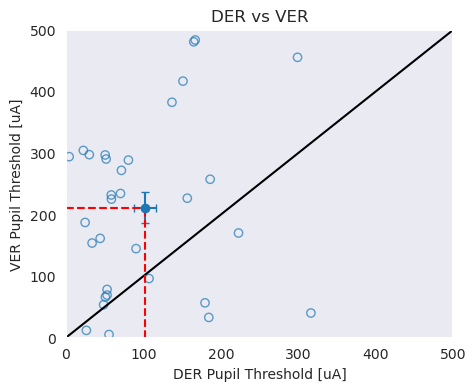

In [36]:
x_data = fit_res[['pp_threshold']][fit_res['ep_r_squared']>gof_level].values*500
y_data = fit_res[['ep_threshold']][fit_res['ep_r_squared']>gof_level].values*500

fig,ax = plt.subplots(1,1, figsize=(5,4))
ax.axline((1, 1), slope=1,color='k', linestyle='-')
ax.scatter(
    x_data, y_data,alpha=.7,edgecolor='tab:blue', facecolor='none'
)
ax.errorbar(x_data.mean(), y_data.mean(), xerr=sem(x_data),yerr=sem(y_data), fmt='o', capsize=3)

ax.set_xlabel('DER Pupil Threshold [uA]')
ax.set_ylabel('VER Pupil Threshold [uA]')
ax.vlines(x=x_data.mean(), ymin=0, ymax=y_data.mean(), colors='red', linestyles='--', label='Vertical Line')
ax.hlines(y=y_data.mean(), xmin=0, xmax=x_data.mean(), colors='red', linestyles='--', label='Vertical Line')
ax.set_title('DER vs VER')
ax.grid(False)
ax.set_xlim([0,500])
ax.set_ylim([0,500])